
<div style="background-color: #eee3d3">
<h1> Project presentation </h1>
</div>

## The ultimate goal of this project is to find potential biomarkers, i.e. which variables (peak table columns) have the strongest ability to separate the two sample groups (Incident vs. Non-case).

Resource : [Biomarker Discovery and Validation: Statistical Considerations, FS Ou et al., 2021](https://www.sciencedirect.com/science/article/pii/S1556086421016634)

## These notebooks are guides for the "classical" steps to follow for data analysis applied in metabolomics, especially for biomarker discovery. Feel free to add your own notebooks, functions, plots, etc. Anything more that you create and explain in these notebooks will be taken into account for your evaluation :)

<div style="background-color: #eee3d3">
<h1> 1-explore_data.ipynb </h1>
</div>

# Exploratory data analysis

---

### The aim of this notebook is to explore the peak table with a few visualisations on target (here the Sample Group), missing values, distributions, ...

### Basic ckecklist :

#### Form analysis :
- __target__ : Groups
- __shape (rows & columns)__ : 186 rows (samples) x 562 columns (5 for metadata and 557 compounds)
- __features types__ :
    - qualitative : 4 (SampleID, Groups, TypTumo, CaseHCCWide)
    - quantitative (int) : 1 (MatchCaseset)
    - quantitative (float) : 557 (compounds)
- __missing values__ :
    - compounds can be in every sample (0% of missing values), in most of them or just in a few
    - the maximum of missing value for a variable is 49.5%, i.e. this variable is absent from 49.5% of the samples
    - (samples seem to be more easily separated with not too much missing values)

#### Content analysis :
- __target visualisation__ :
    - ratio 1:1 (93 Cancer - 93 Healthy)
- __feature visualisation__ :
    - on the first 10 compounds, most of them follow a normal distribution
    - some of them follow a double normal distribution
    - maybe one distribution for each class (Healthy vs Cancer) --> hypothesis
- __relation features/target__ :
    - on the first 10 compounds, we don't see a clear difference of intensity between the Cancer and Healthy samples --> previous hypothesis rejected on these features --> may be true for other features
- __relation features/features__ : strong correlations between some of the features --> need to reduce the dimension for further analysis

# Import modules

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.decomposition import PCA
import cimcb_lite as cb

# Import useful functions

In [2]:
import os
import sys
sys.path.append('/'.join(os.getcwd().split('/')[:-1]) + '/bin/')

from explore_data_functions import PCA_paired, PCA_3D, shapiro_test_df, paired_ttest_df, paired_ttest_or_Wilcoxon

# Import peak table and create variable X (peakTable without metadata columns)

In [3]:
path_peakTable = '/'.join(os.getcwd().split('/')[:-1]) + '/data/peakTable/original_peak_table/peakTable_HILIC_POS.csv'
path_peakTable

'/home/thomas/Documents/5eme/MedialGenomics/ProjetGenomique/ML_notebooks/data/peakTable/original_peak_table/peakTable_HILIC_POS.csv'

In [4]:
peakTable_HILIC_POS = pd.read_csv(path_peakTable, sep=',', decimal='.', na_values='NA')

Metadata :
- __SampleID__ : sample ID and associated filename
- __Groups__ : either the sample is Incident (Cancer case) or Non-case (Control).
- __MatchCaseset__ : Each cancer case is associated to a paired-control. The point is to associate each cancer case to a control with the close phenotype (height, weight, BMI, sport activity, alcohol consumption, smoking history, ...) to reduce the variabilty. For the statistical analysis, don't forget to take this information into account (paired test)
- __TypTumo__ : For Non-case patients, the value is NaN. For Incident patient, there are two types of tumor (HCC or HCC_Wide). 

For further analysis, you can :
- first consider that the target value to predict is __Groups__ (Incident vs. Non-case) $\rightarrow$ classification
- second also consider the type of tumor __TypTumo__ $\rightarrow$ stratification

In [5]:
peakTable_HILIC_POS.head()

SampleID    Groups  MatchCaseset   TypTumo CaseHCCWide  variable_3  \
0  LivCan_153  Incident            82       HCC         Yes   19.761786   
1  LivCan_154  Non-case            82       NaN          No   19.735279   
2  LivCan_267  Incident           427       HCC         Yes   19.116076   
3  LivCan_268  Non-case           427       NaN          No   19.376875   
4  LivCan_299  Incident           376  HCC_Wide         Yes   19.555938   

   variable_5  variable_6  variable_7  variable_8  ...  variable_2339  \
0   14.635833   22.185582   16.414744   12.615143  ...      12.052252   
1   15.193396   20.831414   15.052533         NaN  ...      13.020365   
2   15.446714   22.152604   16.410827         NaN  ...            NaN   
3   15.460525   22.169389   16.403964   12.720767  ...            NaN   
4   14.515536   22.150249   16.372219   12.314019  ...            NaN   

   variable_2340  variable_2350  variable_2353  variable_2364  variable_2365  \
0      12.568647      13.192848      13.230752      12.248590      12.114328   
1      12.928643      13.697314            NaN      12.604052            NaN   
2            NaN            NaN      13.330175            NaN            NaN   
3            NaN      13.086805      13.304171            NaN      11.605353   
4            NaN            NaN      13.306722      12.349830      11.926237   

   variable_2368  variable_2370  variable_2375  variable_2379  
0      14.269258      12.355017      13.114289      13.882526  
1            NaN      12.208084            NaN            NaN  
2      14.215988            NaN      12.955618      13.778398  
3      14.284148      12.319119      13.058285      13.812829  
4      14.192775            NaN      13.006556      13.841201  

[5 rows x 562 columns]

In [6]:
peakTable_HILIC_POS.shape

(186, 562)

The peak table contains 186rows (samples), 562 columns (5 for metadata and 557 compounds)

On crée une table X qui contient uniquement les valeurs pour chaque échantillon.

In [7]:
X = peakTable_HILIC_POS.iloc[:, ['variable' in col for col in peakTable_HILIC_POS.columns]]

In [8]:
X.head()

variable_3  variable_5  variable_6  variable_7  variable_8  variable_10  \
0   19.761786   14.635833   22.185582   16.414744   12.615143    15.580604   
1   19.735279   15.193396   20.831414   15.052533         NaN    15.145423   
2   19.116076   15.446714   22.152604   16.410827         NaN    14.628890   
3   19.376875   15.460525   22.169389   16.403964   12.720767    15.937169   
4   19.555938   14.515536   22.150249   16.372219   12.314019    14.950203   

   variable_11  variable_14  variable_22  variable_23  ...  variable_2339  \
0    15.881437    17.500899    12.792893    16.805604  ...      12.052252   
1    14.034654    17.953780          NaN    15.907714  ...      13.020365   
2    15.316772    17.404715    12.786407    15.947176  ...            NaN   
3    15.967749    15.836957          NaN    16.371211  ...            NaN   
4    15.294906    16.610171    12.214057    16.171763  ...            NaN   

   variable_2340  variable_2350  variable_2353  variable_2364  variable_2365  \
0      12.568647      13.192848      13.230752      12.248590      12.114328   
1      12.928643      13.697314            NaN      12.604052            NaN   
2            NaN            NaN      13.330175            NaN            NaN   
3            NaN      13.086805      13.304171            NaN      11.605353   
4            NaN            NaN      13.306722      12.349830      11.926237   

   variable_2368  variable_2370  variable_2375  variable_2379  
0      14.269258      12.355017      13.114289      13.882526  
1            NaN      12.208084            NaN            NaN  
2      14.215988            NaN      12.955618      13.778398  
3      14.284148      12.319119      13.058285      13.812829  
4      14.192775            NaN      13.006556      13.841201  

[5 rows x 557 columns]

In [9]:
X.shape

(186, 557)

# Form analysis

### Feature types

In [10]:
peakTable_HILIC_POS.dtypes.value_counts()

float64    557
object       4
int64        1
dtype: int64

In [11]:
peakTable_HILIC_POS.dtypes[peakTable_HILIC_POS.dtypes == 'int64']

MatchCaseset    int64
dtype: object

In [12]:
peakTable_HILIC_POS.dtypes[peakTable_HILIC_POS.dtypes == 'object']

SampleID       object
Groups         object
TypTumo        object
CaseHCCWide    object
dtype: object

## Balance in target feature

In [13]:
peakTable_HILIC_POS['Groups'].value_counts()

Incident    93
Non-case    93
Name: Groups, dtype: int64

<AxesSubplot:>

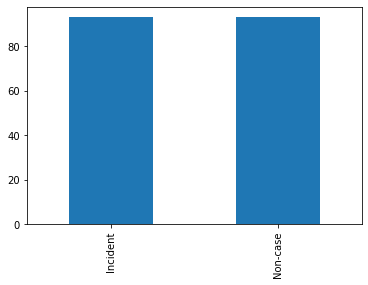

In [14]:
peakTable_HILIC_POS['Groups'].value_counts().plot.bar()

#### Ratio 1:1 between Healthy and Cancer patients --> consider the samples as a set of couples. We have a metadata file in which we have the paired samples, we will use later in the analysis.

## Heatmap of missing value

This representation enables to see the global distribution of missing values (black dots) across the peak table.

<AxesSubplot:>

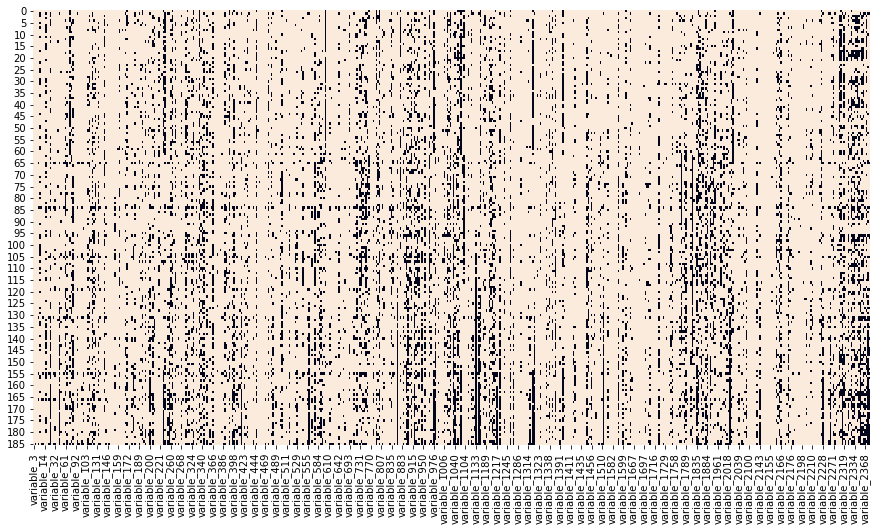

In [15]:
plt.figure(figsize=(15,8))
sns.heatmap(X.notna(), cbar=False)

In [16]:
X.isna()

variable_3  variable_5  variable_6  variable_7  variable_8  variable_10  \
0         False       False       False       False       False        False   
1         False       False       False       False        True        False   
2         False       False       False       False        True        False   
3         False       False       False       False       False        False   
4         False       False       False       False       False        False   
..          ...         ...         ...         ...         ...          ...   
181       False       False       False       False       False        False   
182       False       False       False       False       False        False   
183       False       False       False       False       False        False   
184       False       False       False       False       False        False   
185       False        True       False        True       False         True   

     variable_11  variable_14  variable_22  variable_23  ...  variable_2339  \
0          False        False        False        False  ...          False   
1          False        False         True        False  ...          False   
2          False        False        False        False  ...           True   
3          False        False         True        False  ...           True   
4          False        False        False        False  ...           True   
..           ...          ...          ...          ...  ...            ...   
181        False        False        False        False  ...          False   
182        False        False        False        False  ...          False   
183        False        False        False        False  ...          False   
184        False        False        False        False  ...          False   
185         True        False        False        False  ...          False   

     variable_2340  variable_2350  variable_2353  variable_2364  \
0            False          False          False          False   
1            False          False           True          False   
2             True           True          False           True   
3             True          False          False           True   
4             True           True          False          False   
..             ...            ...            ...            ...   
181          False          False           True           True   
182          False           True           True          False   
183          False           True           True          False   
184          False           True           True          False   
185          False          False           True           True   

     variable_2365  variable_2368  variable_2370  variable_2375  variable_2379  
0            False          False          False          False          False  
1             True           True          False           True           True  
2             True          False           True          False          False  
3            False          False          False          False          False  
4            False          False           True          False          False  
..             ...            ...            ...            ...            ...  
181           True           True           True           True           True  
182          False          False          False           True           True  
183           True           True          False           True           True  
184           True           True           True           True           True  
185           True           True          False           True           True  

[186 rows x 557 columns]

In [17]:
perc_mv = X.isna().sum() / X.shape[0]
perc_mv

variable_3       0.000000
variable_5       0.005376
variable_6       0.000000
variable_7       0.032258
variable_8       0.268817
                   ...   
variable_2365    0.413978
variable_2368    0.161290
variable_2370    0.360215
variable_2375    0.387097
variable_2379    0.215054
Length: 557, dtype: float64

In [18]:
perc_mv.max()

0.4946236559139785

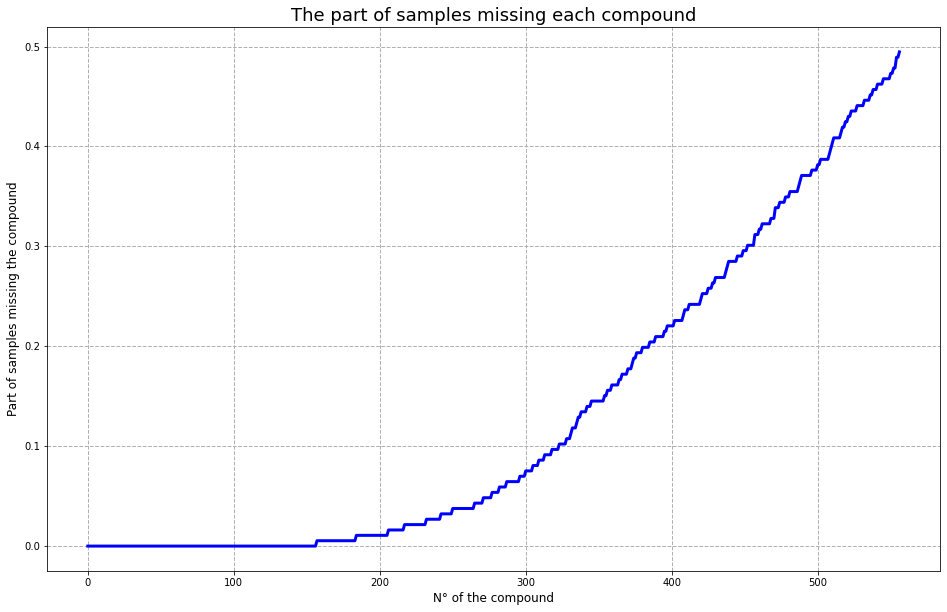

In [19]:
plt.figure(figsize=(16,10))
plt.plot(perc_mv.sort_values().values, color='b', linewidth=3)
plt.xlabel('N° of the compound', fontsize=12)
plt.ylabel('Part of samples missing the compound', fontsize=12)
plt.title('The part of samples missing each compound', fontsize=18)
plt.grid(linestyle='--', linewidth=1)
plt.show()

## Plot a first PCA

In [20]:
X_ = X.copy()

In [21]:
X_[X_.isna()] = 1

In [22]:
X_

variable_3  variable_5  variable_6  variable_7  variable_8  variable_10  \
0     19.761786   14.635833   22.185582   16.414744   12.615143    15.580604   
1     19.735279   15.193396   20.831414   15.052533    1.000000    15.145423   
2     19.116076   15.446714   22.152604   16.410827    1.000000    14.628890   
3     19.376875   15.460525   22.169389   16.403964   12.720767    15.937169   
4     19.555938   14.515536   22.150249   16.372219   12.314019    14.950203   
..          ...         ...         ...         ...         ...          ...   
181   19.664978   14.447858   20.808503   15.027154   12.648327    14.806952   
182   19.301954   14.839941   21.085175   15.321075   12.510670    14.488147   
183   19.170626   14.291711   21.381912   15.197205   12.499558    14.434959   
184   18.869505   14.440576   20.961485   14.829978   12.312338    14.114074   
185   18.954904    1.000000   20.005032    1.000000   12.414258     1.000000   

     variable_11  variable_14  variable_22  variable_23  ...  variable_2339  \
0      15.881437    17.500899    12.792893    16.805604  ...      12.052252   
1      14.034654    17.953780     1.000000    15.907714  ...      13.020365   
2      15.316772    17.404715    12.786407    15.947176  ...       1.000000   
3      15.967749    15.836957     1.000000    16.371211  ...       1.000000   
4      15.294906    16.610171    12.214057    16.171763  ...       1.000000   
..           ...          ...          ...          ...  ...            ...   
181    14.244917    17.126579    12.080710    15.388376  ...      12.349299   
182    15.163197    16.816591    12.452644    16.474456  ...      12.909283   
183    14.520558    16.315887    12.808417    15.613263  ...      12.846355   
184    13.776358    16.110117    12.667428    16.021372  ...      12.477753   
185     1.000000    15.432975    12.047361    15.443640  ...      13.225899   

     variable_2340  variable_2350  variable_2353  variable_2364  \
0        12.568647      13.192848      13.230752      12.248590   
1        12.928643      13.697314       1.000000      12.604052   
2         1.000000       1.000000      13.330175       1.000000   
3         1.000000      13.086805      13.304171       1.000000   
4         1.000000       1.000000      13.306722      12.349830   
..             ...            ...            ...            ...   
181      11.505004      13.189121       1.000000       1.000000   
182      12.642143       1.000000       1.000000      12.708850   
183      13.243400       1.000000       1.000000      12.199647   
184      11.789382       1.000000       1.000000      11.628154   
185      12.978890      11.596877       1.000000       1.000000   

     variable_2365  variable_2368  variable_2370  variable_2375  variable_2379  
0        12.114328      14.269258      12.355017      13.114289      13.882526  
1         1.000000       1.000000      12.208084       1.000000       1.000000  
2         1.000000      14.215988       1.000000      12.955618      13.778398  
3        11.605353      14.284148      12.319119      13.058285      13.812829  
4        11.926237      14.192775       1.000000      13.006556      13.841201  
..             ...            ...            ...            ...            ...  
181       1.000000       1.000000       1.000000       1.000000       1.000000  
182      12.462751      12.175110      12.635066       1.000000       1.000000  
183       1.000000       1.000000      12.258149       1.000000       1.000000  
184       1.000000       1.000000       1.000000       1.000000       1.000000  
185       1.000000       1.000000      12.158923       1.000000       1.000000  

[186 rows x 557 columns]

In [23]:
cb.plot.pca(X_, pcx=1, pcy=2, group_label=peakTable_HILIC_POS['Groups'])

Loading BokehJS ...

PCA selon PC1 et PC2:

Les clusters formés selon les groupes incident/non-case sont globalement confondus.
On observe la formation de deux zones mais elles ne correspondent pas aux deux groupes.

In [24]:
cb.plot.pca(X_, pcx=1, pcy=3, group_label=peakTable_HILIC_POS['Groups'])

Loading BokehJS ...

PCA selon PC1 et PC:

Même conclusion, on observe toujours deux zones mais elles ne correspondent pas aux groupes incident/non-case.

In [25]:
PCA_3D(X_, peakTable_HILIC_POS)

PCA selon PC1, PC2 et PC3:

    Pas plus marquant (mais la visualisation en 3D est stylée)

In [26]:
PCA_paired(X_, peakTable_HILIC_POS)

# Content analysis

## Target visualisation

In [27]:
peakTable_HILIC_POS['Groups'].value_counts()

Incident    93
Non-case    93
Name: Groups, dtype: int64

<AxesSubplot:>

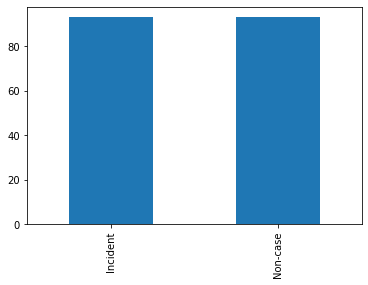

In [28]:
peakTable_HILIC_POS['Groups'].value_counts().plot.bar()

Ratio 1:1, each patient has a matched control

## Metadata visualisation

In [29]:
peakTable_HILIC_POS.head()

SampleID    Groups  MatchCaseset   TypTumo CaseHCCWide  variable_3  \
0  LivCan_153  Incident            82       HCC         Yes   19.761786   
1  LivCan_154  Non-case            82       NaN          No   19.735279   
2  LivCan_267  Incident           427       HCC         Yes   19.116076   
3  LivCan_268  Non-case           427       NaN          No   19.376875   
4  LivCan_299  Incident           376  HCC_Wide         Yes   19.555938   

   variable_5  variable_6  variable_7  variable_8  ...  variable_2339  \
0   14.635833   22.185582   16.414744   12.615143  ...      12.052252   
1   15.193396   20.831414   15.052533         NaN  ...      13.020365   
2   15.446714   22.152604   16.410827         NaN  ...            NaN   
3   15.460525   22.169389   16.403964   12.720767  ...            NaN   
4   14.515536   22.150249   16.372219   12.314019  ...            NaN   

   variable_2340  variable_2350  variable_2353  variable_2364  variable_2365  \
0      12.568647      13.192848      13.230752      12.248590      12.114328   
1      12.928643      13.697314            NaN      12.604052            NaN   
2            NaN            NaN      13.330175            NaN            NaN   
3            NaN      13.086805      13.304171            NaN      11.605353   
4            NaN            NaN      13.306722      12.349830      11.926237   

   variable_2368  variable_2370  variable_2375  variable_2379  
0      14.269258      12.355017      13.114289      13.882526  
1            NaN      12.208084            NaN            NaN  
2      14.215988            NaN      12.955618      13.778398  
3      14.284148      12.319119      13.058285      13.812829  
4      14.192775            NaN      13.006556      13.841201  

[5 rows x 562 columns]

### TypTumo : Type of tumor, i.e. HCC or HCC Wide

In [30]:
peakTable_HILIC_POS['TypTumo'].value_counts(dropna=False)

NaN         93
HCC         80
HCC_Wide    13
Name: TypTumo, dtype: int64

<AxesSubplot:>

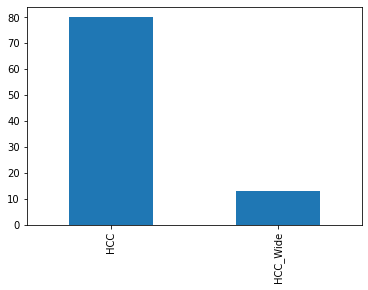

In [31]:
peakTable_HILIC_POS['TypTumo'].value_counts().plot.bar()

On travaille avec plus de cas avérés (HCC) que de cas supposés d'après les symptômes du patient (HCC_Wide).
On a donc deux types d'infos:
- d'abord, en considérant que les données *HCC_Wide* sont aussi sûres que les données *HCC*, on devrait pouvoir conclure sur les métabolites qui permettraient le mieux de distinguer un individu sain d'un individu malade en comparant les groupes incident et non-case; 
- ensuite, en comparant les données *HCC_Wide* à la classification entre sain et malade, on pourrait éliminer les cas compris dans *HCC_Wide* qui ne sont en fait pas des cancers (ou pas *ce* cancer).

### MatchCaseset : ID for paired samples

Les paires sont identifiables par la colonne *MatchCaseset*: les deux individus d'une même paire ont la même valeur.

In [32]:
all(peakTable_HILIC_POS['MatchCaseset'].value_counts() == 2)

True

All samples are indeed in paires

## Feature visualisation

The following visualisations show the distributions of the first 10 features of the peak table.

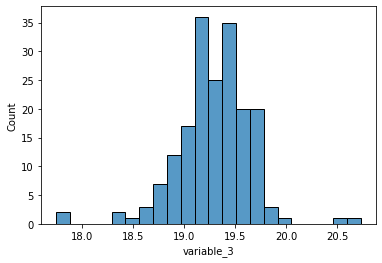

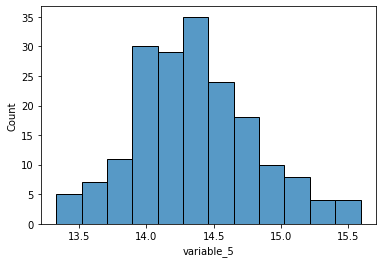

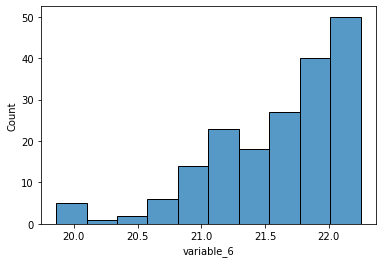

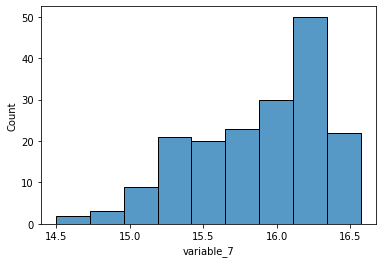

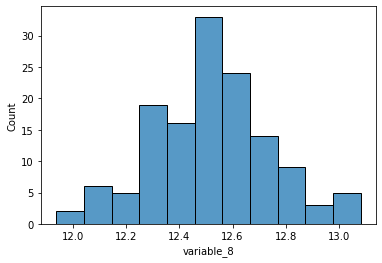

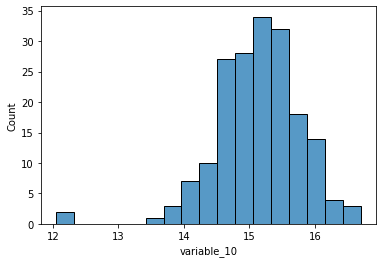

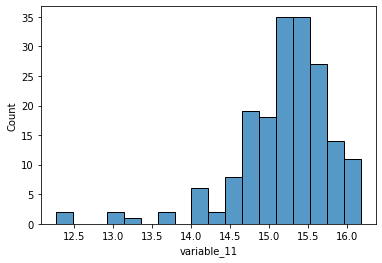

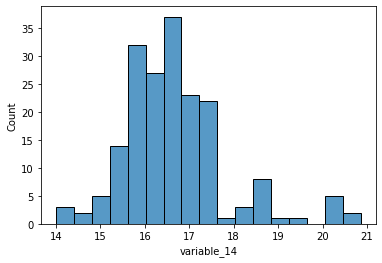

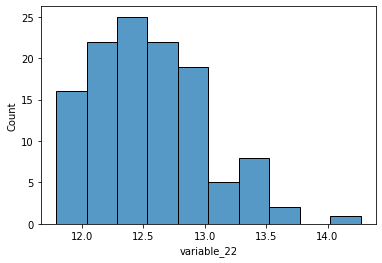

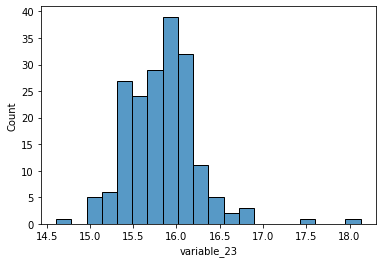

In [33]:
for col in X.columns[0:10]:
    
    plt.figure()
    sns.histplot(X[col])

Some of the compounds seem to be normally distributed, some other present extreme values. We can maybe think that these non-normal distribution show the difference between Healthy and Patient samples ?

Pour vérifier cette hypothèse, on visualise les distributions par métabolites et par groupe: on aurait alors deux distributions normales plus ou moins superposées?

### Feature visualisation, separated according to group

------------------------------------------------------------------------------------------------------------------------


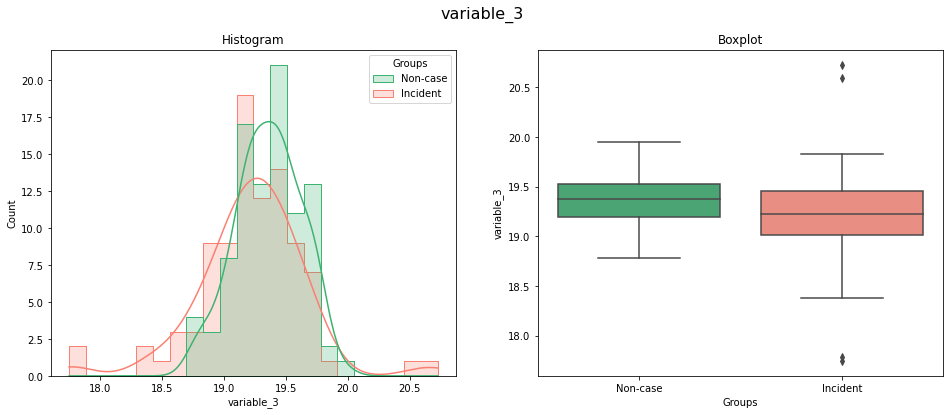

------------------------------------------------------------------------------------------------------------------------


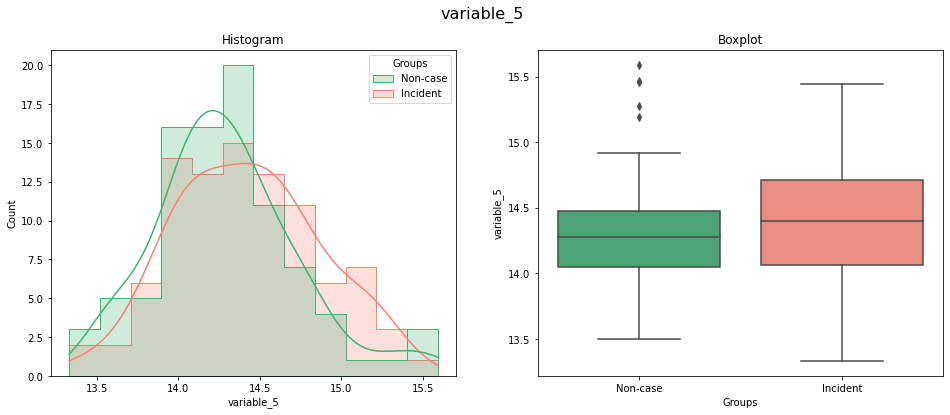

------------------------------------------------------------------------------------------------------------------------


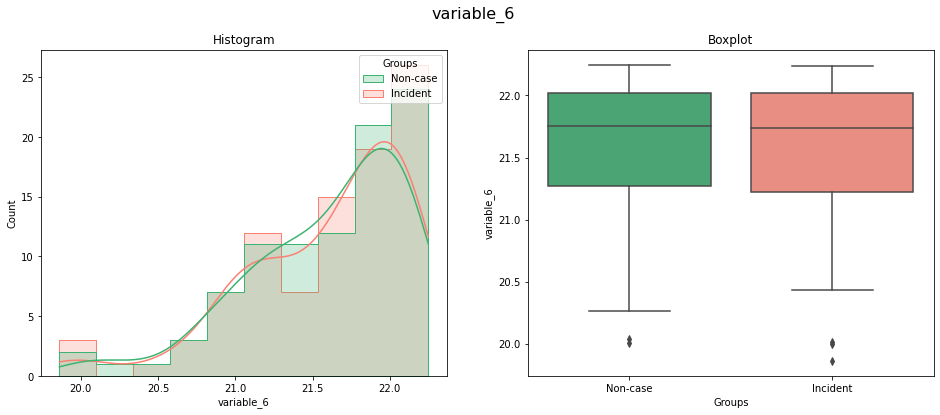

------------------------------------------------------------------------------------------------------------------------


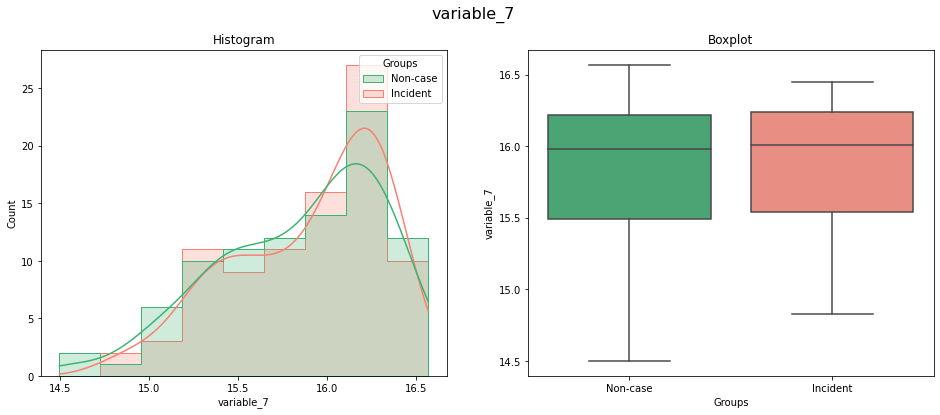

------------------------------------------------------------------------------------------------------------------------


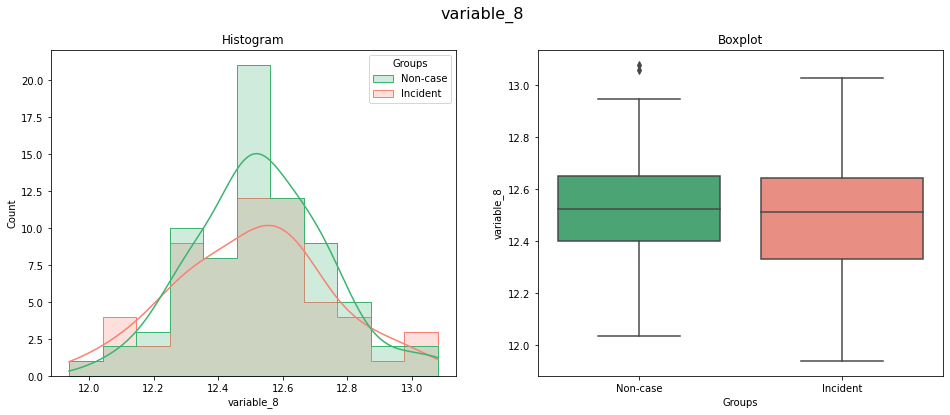

------------------------------------------------------------------------------------------------------------------------


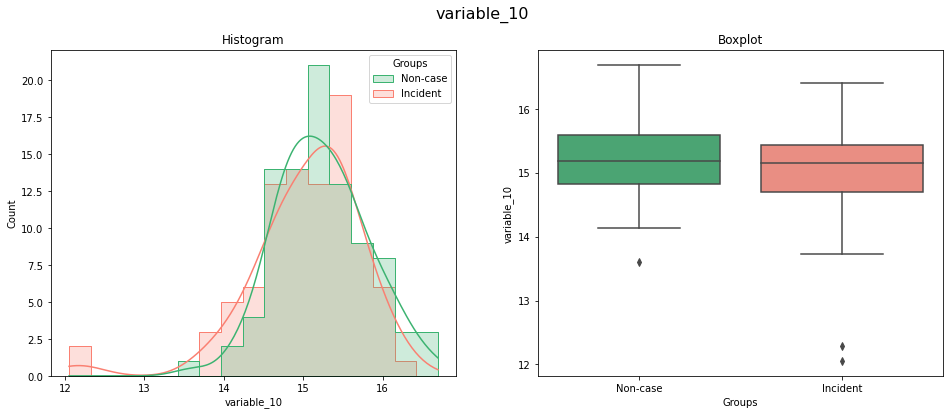

------------------------------------------------------------------------------------------------------------------------


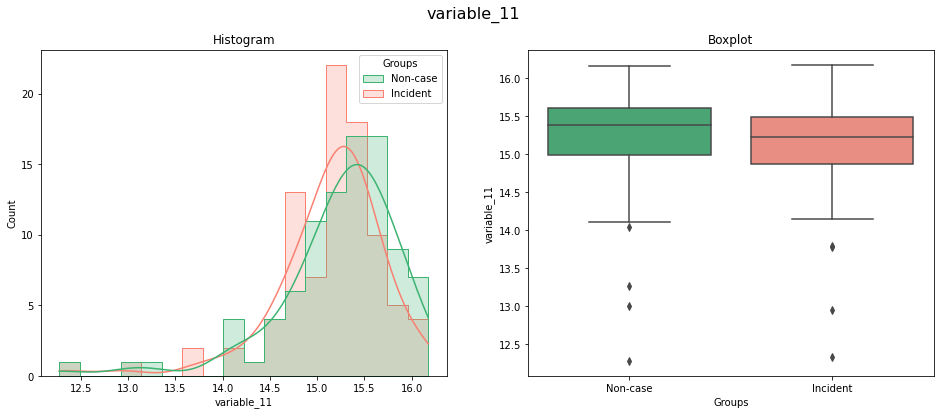

------------------------------------------------------------------------------------------------------------------------


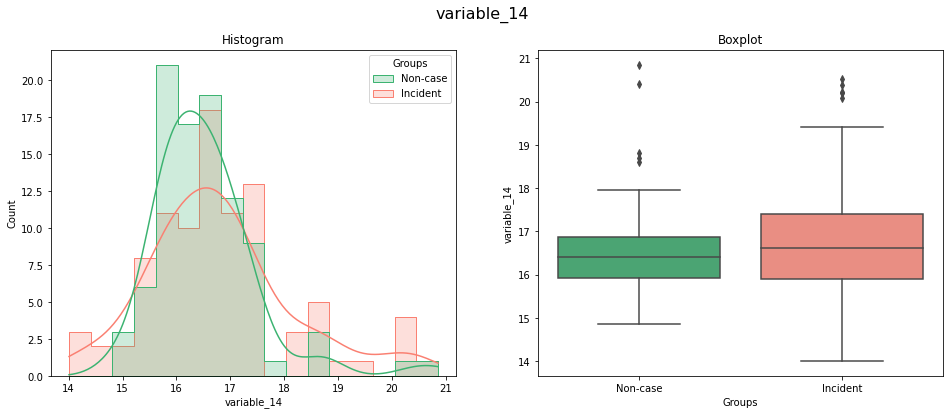

------------------------------------------------------------------------------------------------------------------------


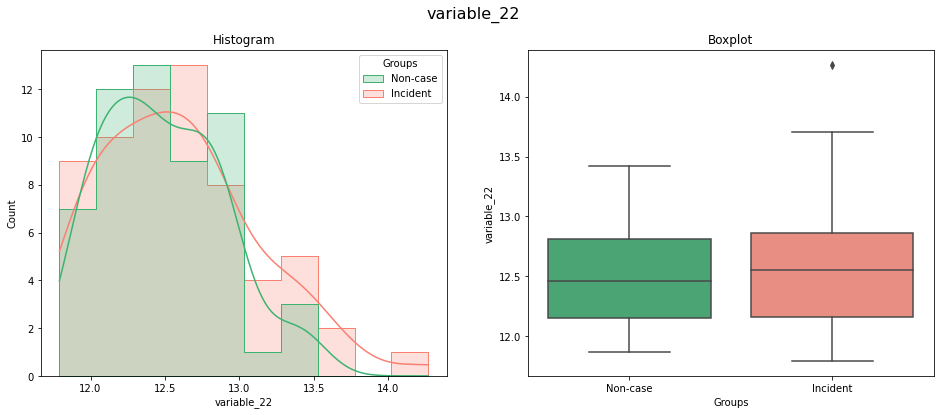

------------------------------------------------------------------------------------------------------------------------


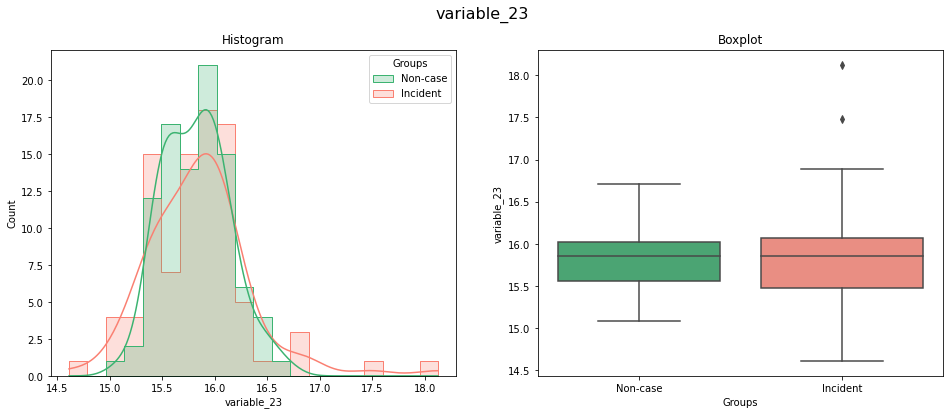

In [34]:
palette = {'Incident': 'salmon', 'Non-case': 'mediumseagreen'}

for col in [col for col in peakTable_HILIC_POS.columns if 'variable' in col][:10]:
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=peakTable_HILIC_POS, x=peakTable_HILIC_POS[col], hue='Groups', hue_order=['Non-case', 'Incident'], kde=True, element='step', palette=palette)
    plt.title('Histogram')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Groups', y=col, data=peakTable_HILIC_POS, order=['Non-case', 'Incident'], palette=palette)
    plt.title('Boxplot')
    
    plt.suptitle(col, fontsize=16)
    
    print(120 * '-')
    
    plt.show()

On this visualisations, it is really difficult to see a clear difference between the Incident and Non-case groups.

Les distributions (par métabolites et par groupe) ne sont pas (toutes) normales, mais sont de "forme" semblable (=même distribution) entre non-case et incident.

### Feature visualisation, separated according to group and tumor type

In [35]:
peakTable_copy = peakTable_HILIC_POS.copy()

peakTable_copy['TypTumo'] = peakTable_copy['TypTumo'].fillna('Non-case')

In [36]:
peakTable_copy.head()

SampleID    Groups  MatchCaseset   TypTumo CaseHCCWide  variable_3  \
0  LivCan_153  Incident            82       HCC         Yes   19.761786   
1  LivCan_154  Non-case            82  Non-case          No   19.735279   
2  LivCan_267  Incident           427       HCC         Yes   19.116076   
3  LivCan_268  Non-case           427  Non-case          No   19.376875   
4  LivCan_299  Incident           376  HCC_Wide         Yes   19.555938   

   variable_5  variable_6  variable_7  variable_8  ...  variable_2339  \
0   14.635833   22.185582   16.414744   12.615143  ...      12.052252   
1   15.193396   20.831414   15.052533         NaN  ...      13.020365   
2   15.446714   22.152604   16.410827         NaN  ...            NaN   
3   15.460525   22.169389   16.403964   12.720767  ...            NaN   
4   14.515536   22.150249   16.372219   12.314019  ...            NaN   

   variable_2340  variable_2350  variable_2353  variable_2364  variable_2365  \
0      12.568647      13.192848      13.230752      12.248590      12.114328   
1      12.928643      13.697314            NaN      12.604052            NaN   
2            NaN            NaN      13.330175            NaN            NaN   
3            NaN      13.086805      13.304171            NaN      11.605353   
4            NaN            NaN      13.306722      12.349830      11.926237   

   variable_2368  variable_2370  variable_2375  variable_2379  
0      14.269258      12.355017      13.114289      13.882526  
1            NaN      12.208084            NaN            NaN  
2      14.215988            NaN      12.955618      13.778398  
3      14.284148      12.319119      13.058285      13.812829  
4      14.192775            NaN      13.006556      13.841201  

[5 rows x 562 columns]

------------------------------------------------------------------------------------------------------------------------


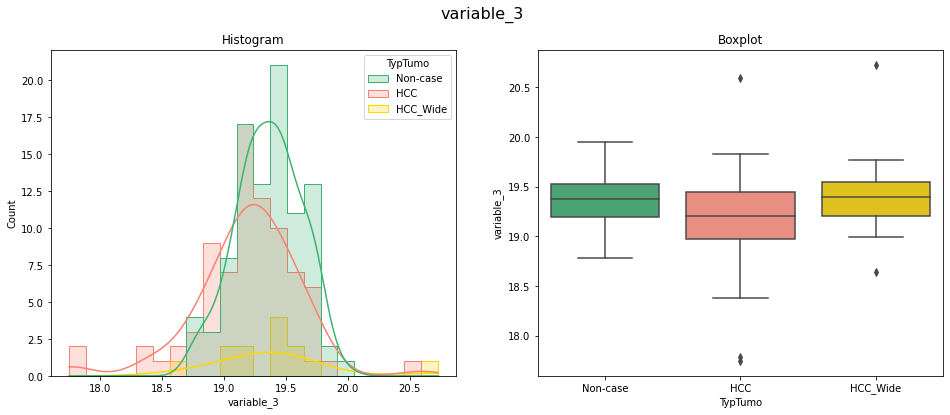

------------------------------------------------------------------------------------------------------------------------


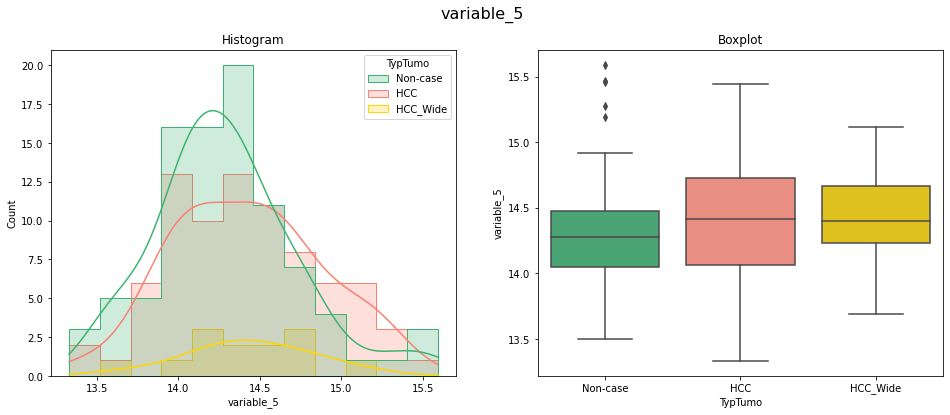

------------------------------------------------------------------------------------------------------------------------


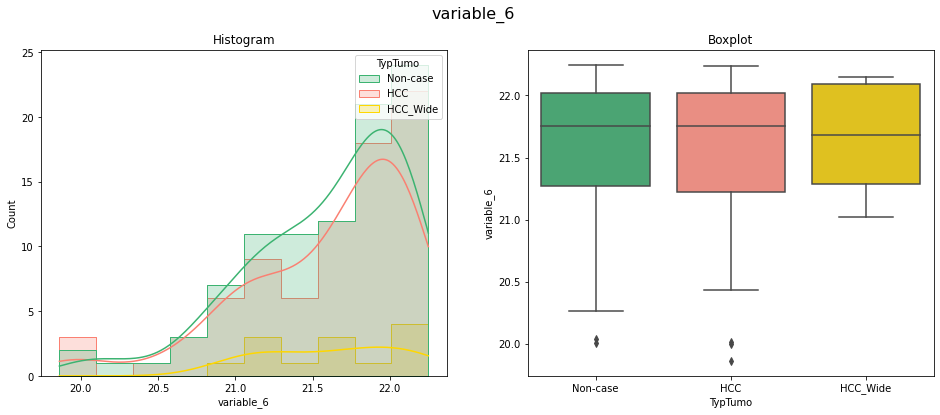

------------------------------------------------------------------------------------------------------------------------


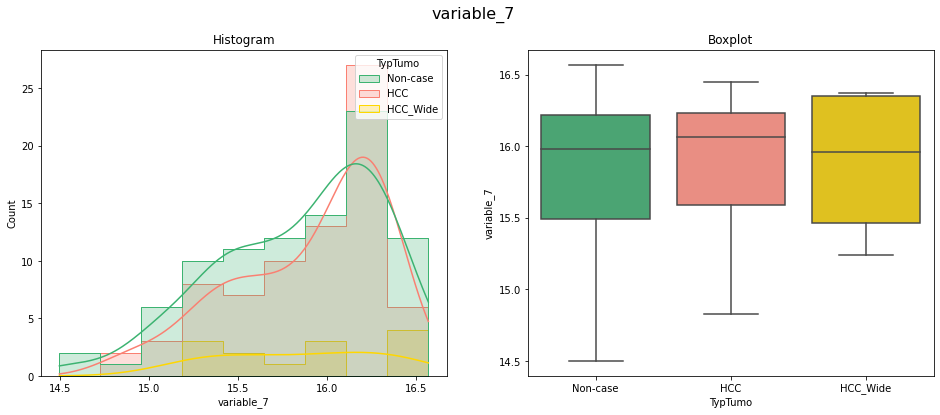

------------------------------------------------------------------------------------------------------------------------


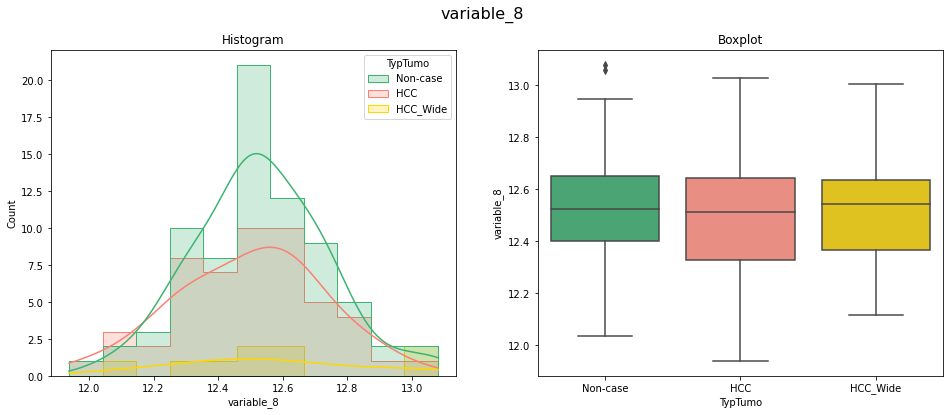

------------------------------------------------------------------------------------------------------------------------


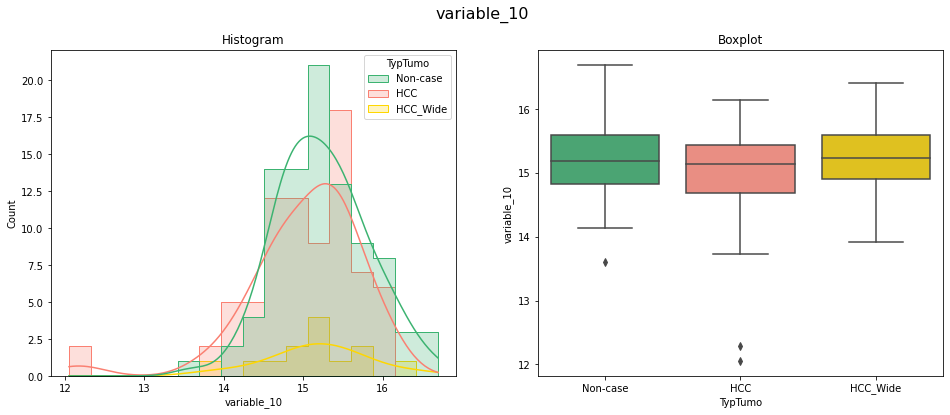

------------------------------------------------------------------------------------------------------------------------


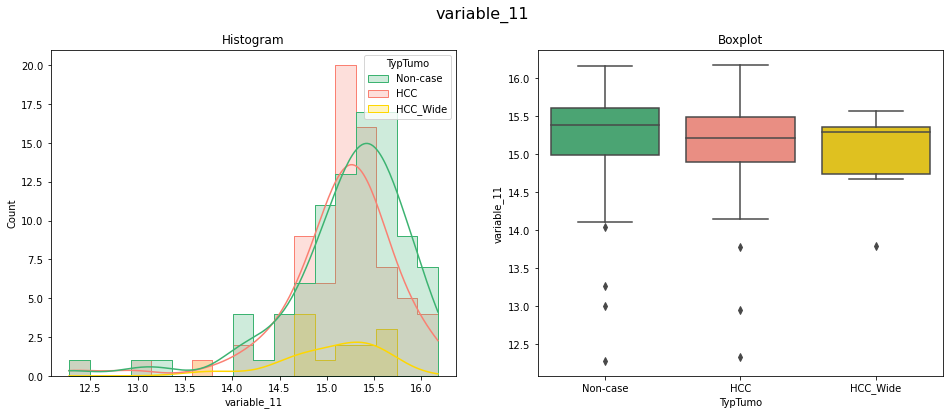

------------------------------------------------------------------------------------------------------------------------


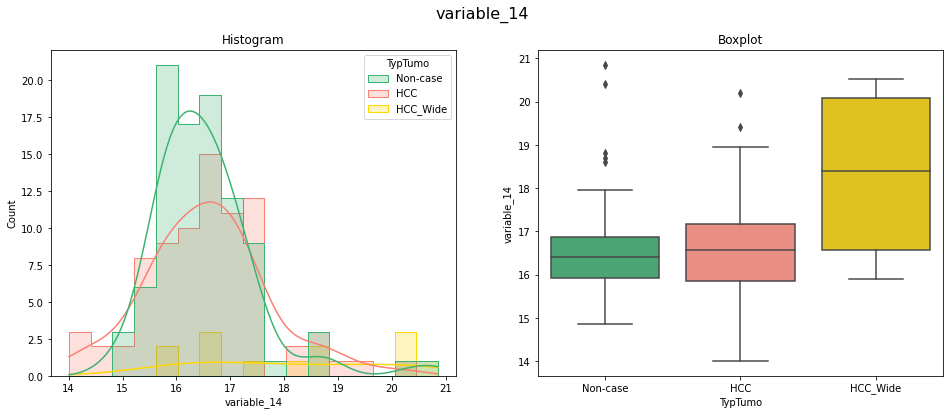

------------------------------------------------------------------------------------------------------------------------


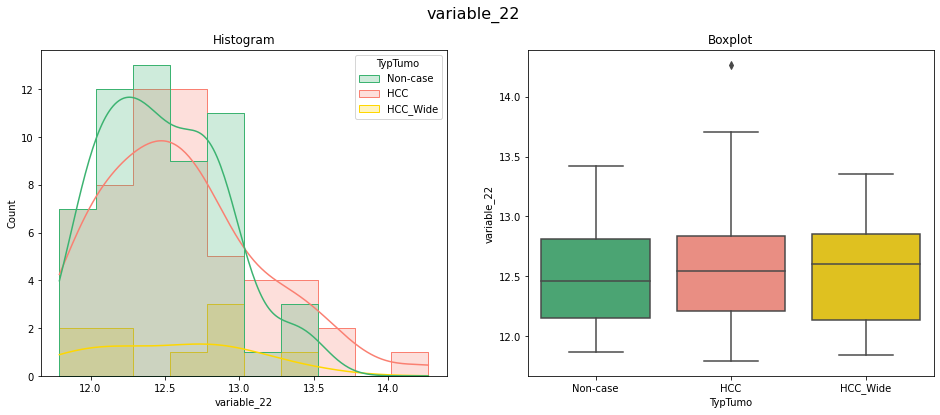

------------------------------------------------------------------------------------------------------------------------


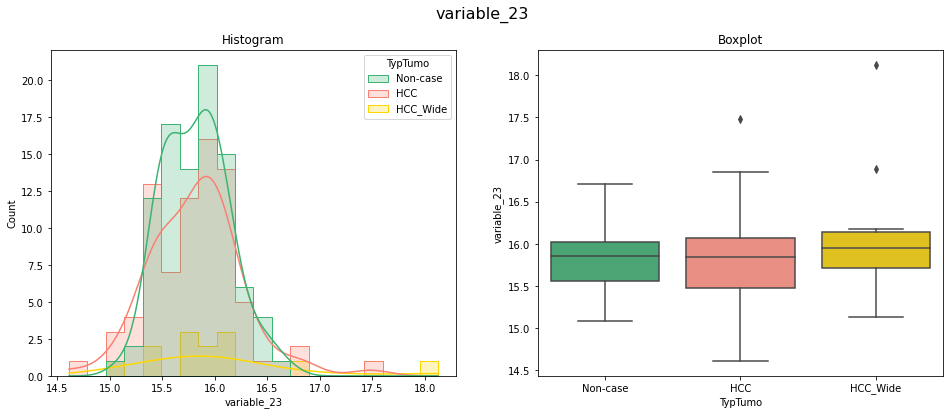

In [37]:
palette = {'Non-case': 'mediumseagreen', 'HCC': 'salmon', 'HCC_Wide': 'gold'}

for col in [col for col in peakTable_copy.columns if 'variable' in col][:10]:
    
    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(data=peakTable_copy, x=peakTable_copy[col], hue='TypTumo', hue_order=['Non-case', 'HCC', 'HCC_Wide'], kde=True, element='step', palette=palette)
    plt.title('Histogram')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='TypTumo', y=col, data=peakTable_copy, order=['Non-case', 'HCC', 'HCC_Wide'], palette=palette)
    plt.title('Boxplot')
    
    plt.suptitle(col, fontsize=16)
    
    print(120 * '-')
    
    plt.show()

Les trois cas, non-case/HCC/HCC_Wide ne semblent pas vraiment différenciés (pas plus de différences visibles qu'entre non-case et incident)

### Visualise feature correlations

On the following heatmap, we can see the correlation table between the features

<AxesSubplot:>

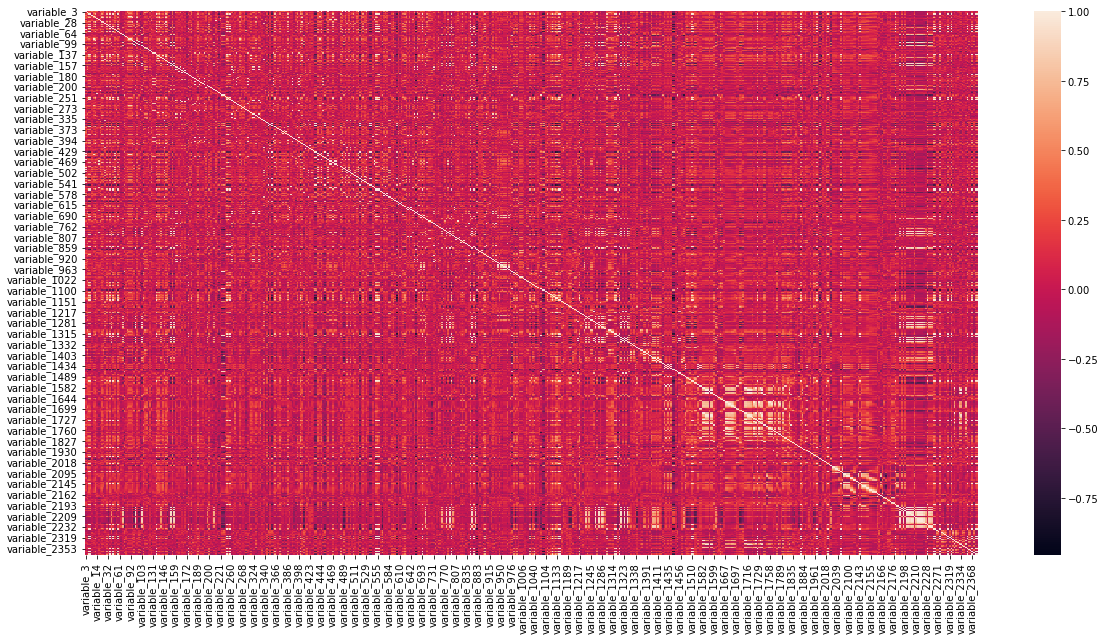

In [38]:
plt.figure(figsize=(20,10))
sns.heatmap(X.corr())

Light dot: haute corrélation positive 

Dark dot: haute corrélation négative

Globalement, il y a peu de métabolites fortement corrélés (et c'est pratique si on veut réussir à les utiliser comme indicateurs).

On this next heatmap, the light dots are the features pairs which have a strong positive or negative correlation

<AxesSubplot:>

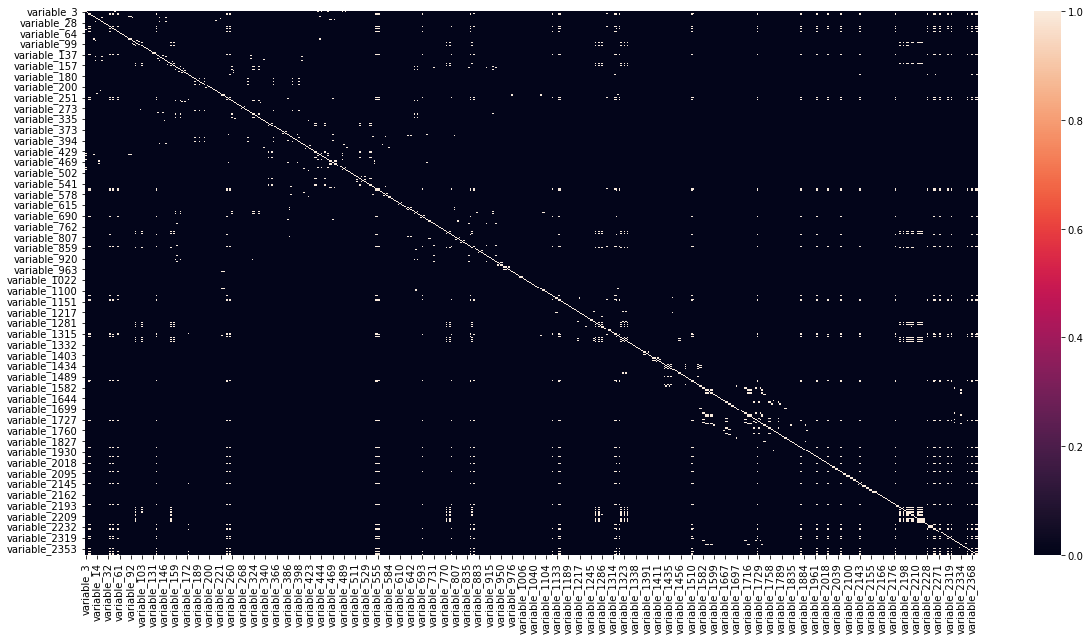

In [39]:
plt.figure(figsize=(20,10))
sns.heatmap((X.corr() > 0.9) | (X.corr() < -0.9))

Pareil mais on voit mieux: peu de métabolites fortement corrélés, et on observe que les métabolites qui ont une forte corrélation aux autres sont souvent les mêmes:par exemple, le métabolite variable_423 a peu de corrélations, alors que le variable_555 en a bien plus. 

--> en théorie, on pourrait réduire la taille du tableau de données en supprimant uniquement les métabolites "redondants", avec beaucoup de corrélations.

### Test of normality with Shapiro-Wilk test : _scipy.stats.shapiro_

In [40]:
shapiro_results_X = shapiro_test_df(X)
shapiro_results_X

shapiro_score        pvalue
Compounds                                 
variable_3          0.937199  3.106757e-07
variable_5          0.986075  6.421676e-02
variable_6          0.897900  5.353651e-10
variable_7          0.936110  3.703076e-07
variable_8          0.993316  7.750993e-01
...                      ...           ...
variable_2365       0.988089  4.508107e-01
variable_2368       0.897646  5.844218e-09
variable_2370       0.990424  5.788468e-01
variable_2375       0.911167  1.317876e-06
variable_2379       0.898007  1.445580e-08

[557 rows x 2 columns]

In [41]:
alpha = 0.05
print('{0:.2f}% of features are normally distributed'.format(len(shapiro_results_X[shapiro_results_X['pvalue'] < alpha]) / len(shapiro_results_X) * 100))

72.35% of features are normally distributed


## Paired tests between two groups (Incident vs Non-case) :
### $\rightarrow$ paired t-test (parametric) or Wilcoxon (non-parametric)

<center>
    <img src="../img/paired_tests.png" alt="Schema for statistical analysis of variable distributions" width="800"/>
</center>


Fonction paired_ttest_or_Wilcoxon:

Pour chaque feature, test de shapiro pour déterminer la normalité ou non de la distribution. Si la distribution *est normale*, on applique un test **paired t-test** pour définir si les distributions incident et non-case sont différenciées selon ce métabolite. Si la distribution *n'est pas normale*, on applique un test de **Wilcoxon** pour évaluer la différence entre les deux distributions pour ce métabolite.

On peut ensuite conclure sur le nombre de métabolites qui présentes une distribution *non-case* et une distribution *incident* différenciées.

In [42]:
test_result = paired_ttest_or_Wilcoxon(peakTable_HILIC_POS, X, alpha=0.05)
test_result

Time to compute : 00:03:03


NormallyDistributed    TestApplied    statistic    pvalue
Variable                                                               
variable_3                  False       Wilcoxon  1270.000000  0.000452
variable_5                   True  Paired t-test     2.644733  0.009630
variable_6                  False       Wilcoxon  2082.000000  0.691685
variable_7                   True  Paired t-test     1.365499  0.175657
variable_8                   True  Paired t-test    -1.091111  0.280671
...                           ...            ...          ...       ...
variable_2365                True  Paired t-test     1.208598  0.235406
variable_2368                True  Paired t-test    -0.425245  0.672042
variable_2370                True  Paired t-test    -0.157771  0.875473
variable_2375                True  Paired t-test     1.237032  0.222353
variable_2379                True  Paired t-test    -0.094349  0.925127

[557 rows x 4 columns]

In [43]:
alpha = 0.01
print('{0:.1f}% of features are significantly differentially distributed'.format(len(test_result[test_result['pvalue'] < alpha]) / len(test_result) * 100))

14.4% of features are significantly differentially distributed


### EXERCISE : Add multiple testing correction to the function <code>paired_ttest_or_Wilcoxon</code>

"Statistical hypothesis testing is based on rejecting the null hypothesis if the likelihood of the observed data under the null hypotheses is low. If multiple hypotheses are tested, the chance of observing a rare event increases, and therefore, the likelihood of incorrectly rejecting a null hypothesis (i.e., making a Type I error) increases." (cf [link](https://en.wikipedia.org/wiki/Bonferroni_correction))

"Multiple testing correction refers to making statistical tests more stringent in order to counteract the problem of multiple testing" (cf. [link](https://en.wikipedia.org/wiki/Multiple_comparisons_problem))

Create a new function <code>paired_ttest_or_Wilcoxon_v2</code>, adding the parameter <code>correction</code> to the existing function <code>paired_ttest_or_Wilcoxon</code>.

You will implement __at least 3 types of correction__ : __original Bonferroni correction__ is required and __Holm–Bonferroni__ method has to be the default method. It's your choice for the other one(s).

le plan: 
    - on peut pas modifier la valeur d'alpha utilisée par la fonction Wilcoxon, donc on est obligé de retravailler dessus *après*
    - prendre les valeurs de p_value obtenues pour chaque test
    - la corriger (waw)
        - donc prévoir trois types de correction, et utiliser l'input "correction" pour choisir lequel on prend
    - ajouter au df
    - print dans le df uniquement les versions corrigées
    - ajouter une colonne qui valide ou non? ou on utilise juste la même commande que juste au dessus

In [44]:
'''
Paired t-test : scipy.stats.ttest_rel
Wilcoxon test : scipy.stats.wilcoxon

For each column in dataframe :
- test with shapiro test if differences between paires are normally distributed
- if yes, performs paired t-test between 'Incident' and 'Non-case' groups
- if no, performs wilcoxon test between 'Incident' and 'Non-case' groups

input :
    - peakTable_HILIC_POS : whole peak table with variable and metadata
    - X : peakTable with only variable columns, no metadata
    - alpha : threshold for shapiro test
    - correction: name of the multiple testing correction to use (values: Bf, H-BF (by default),)
    
return :
    - dataframe with boolean for normal distribution, applied test, statistic and pvalue for each variable (dataframe columns)
'''

def paired_ttest_or_Wilcoxon_v2(peakTable_HILIC_POS, X, alpha=0.05, correction='H-Bf'):
    
    import numpy as np
    import pandas as pd
    
    from scipy.stats import shapiro   
    from scipy.stats import ttest_rel
    from scipy.stats import wilcoxon
    
    import time
    t0 = time.time()

    infos = []
    
    count = 0

    for variable in X.columns:

        curr_var = peakTable_HILIC_POS[['Groups', 'MatchCaseset', variable]]

        val_incident = []
        val_non_case = []
        case_id = []
        val_diff = []

        for elt in np.unique(curr_var['MatchCaseset']):

            curr_case = curr_var[curr_var['MatchCaseset'] == elt]

            case_id.append(elt)
            val_incident.append(curr_case[curr_case['Groups'] == 'Incident'][variable].values[0])
            val_non_case.append(curr_case[curr_case['Groups'] == 'Non-case'][variable].values[0])
            val_diff.append((curr_case[curr_case['Groups'] == 'Incident'][variable].values[0]) - (curr_case[curr_case['Groups'] == 'Non-case'][variable].values[0]))
            
        df_var = pd.concat([pd.Series(case_id), pd.Series(val_incident), pd.Series(val_non_case), pd.Series(val_diff)], axis=1)
        df_var.columns = ['MatchCaseset', 'Incident', 'Non-case', 'Diff']
        
        ech_size = df_var.shape[0]
        
        if shapiro(df_var['Diff'].values).pvalue > alpha:
            
            # difference between paires is normally distributed so paired t-test (parametric)
            normally_distibuted = True
            test_applied = 'Paired t-test'
            
            curr_ttest = ttest_rel(df_var['Incident'].values, df_var['Non-case'].values, nan_policy='omit')
            corrected_pvalue = pvalue_correction(curr_ttest.pvalue, correction, ech_size) # correction
            curr_ttest_values = [variable, normally_distibuted, test_applied, curr_ttest.statistic, corrected_pvalue]
            
        else:
            
            # difference between paires isn't normally distributed so Wilcoxon test (non-parametric)
            normally_distibuted = False
            test_applied = 'Wilcoxon'
            
            curr_ttest = wilcoxon(df_var['Diff'].values)
            corrected_pvalue = pvalue_correction(curr_ttest.pvalue, correction, ech_size) # correction
            curr_ttest_values = [variable, normally_distibuted, test_applied, curr_ttest.statistic, corrected_pvalue]
            
        infos.append(curr_ttest_values)


    infos = pd.DataFrame(np.array(infos))

    infos.columns = ['Variable', 'NormallyDistributed', 'TestApplied', 'statistic', 'pvalue_'+correction]
    infos.index = infos['Variable']
    infos = infos.drop(['Variable'], axis=1)
    infos['statistic'] = infos['statistic'].apply(pd.to_numeric, errors='coerce')
    infos['pvalue-'+correction] = infos['pvalue_'+correction].apply(pd.to_numeric, errors='coerce')
    
    
    print('Time to compute : {0}'.format(time.strftime("%H:%M:%S", time.gmtime(time.time() - t0))))

    return infos

In [45]:
correction='_Bonferroni'
print('pvalue'+correction)

pvalue_Bonferroni


In [46]:
'''
Correct the list of pvalues using the inputed correction type
input :
    - pvalue : (double) pvalue
    - correction: (string) name of the multiple testing correction to use (values: Bf, H-BF (by default),)
    - ech_size : (int) sample size
    
return :
    - corrected pvalue
'''

def pvalue_correction(pvalue, correction, ech_size):
    
    pval = 8
    
    if correction == "Bf":
         pval = pvalue / ech_size

    elif correction == "H-Bf":
        print("coucou")
        
    elif correction == "find another one":
        print("slt")
        
    else:
        print("Correction not recognized")
        
    return pval

In [ ]:
test_result = paired_ttest_or_Wilcoxon_v2(peakTable_HILIC_POS, X, alpha=0.05, correction = "Bf")
test_result